## Spawn dataset data ingest and processing
Here I want to explore data from nours dan ward samples and see if the settling behavior is observed and if it varries depening on development stage of the larvae 

I will try to create a standardized data flow so can be reperposed in the future maybe with evies clam bloom stuff and other future exp sets

to import and merge the data sets I used notebooks from the utils folder DashboardDataPull and IngestIFCBData

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
import os

In [24]:
data_dir = "../IFCBData/spawn/zygotes/merged/" #can add further levels if goiong for zygote
fig_dir = "../Figs/spawn/"

In [4]:
### lets just look at rois over time vs linear for one and then can change to loop over all the things inthe merged directry

In [6]:
merged_df = pd.read_csv("../IFCBData/spawn/zygotes/merged/D20240501T182329_IFCB145_adc_only.csv")

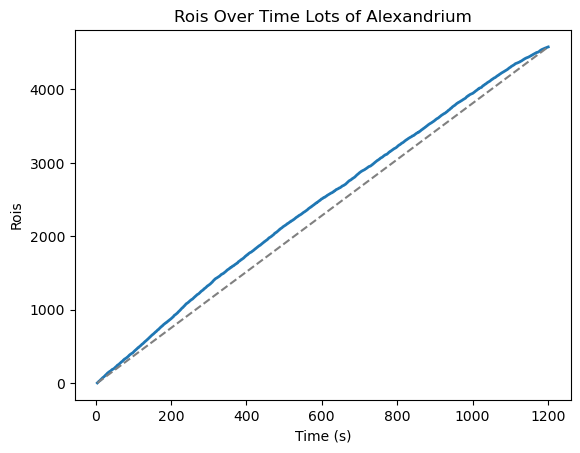

In [7]:
plt.plot(merged_df['RunTime'], merged_df['RoiNumber'], linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Rois")
#plt.ylim(0, 1)
plt.title("Rois Over Time Lots of Alexandrium")
# Get first and last points
x_start, y_start = merged_df["RunTime"].iloc[0], merged_df["RoiNumber"].iloc[0]
x_end, y_end     = merged_df["RunTime"].iloc[-1], merged_df["RoiNumber"].iloc[-1]
# Add straight reference line (first → last point)
plt.plot([x_start, x_end], [y_start, y_end],
        linestyle="--", color="gray", label="linear reference")
plt.show()

In [8]:
## to loop and beyond!

In [12]:
# Each with there own linear?

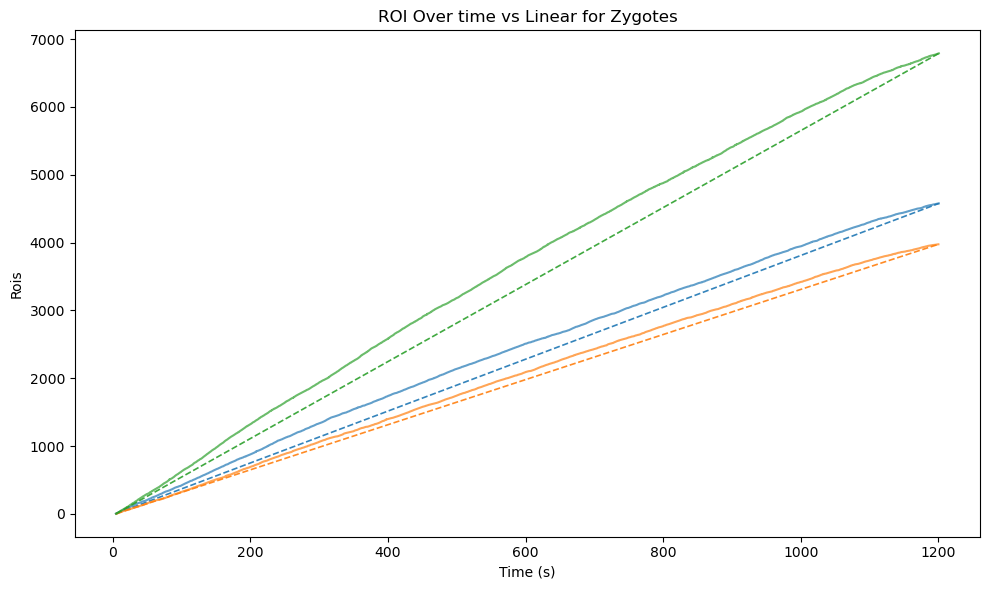

In [30]:

data_dir = data_dir

plt.figure(figsize=(10, 6))

for fname in sorted(os.listdir(data_dir)):
    if not fname.lower().endswith(".csv"):
        continue

    df = pd.read_csv(os.path.join(data_dir, fname))

    # Force numeric (prevents weird string sorting / plotting issues)
    df["RunTime"] = pd.to_numeric(df["RunTime"], errors="coerce")
    df["RoiNumber"] = pd.to_numeric(df["RoiNumber"], errors="coerce")
    df = df.dropna(subset=["RunTime", "RoiNumber"]).sort_values("RunTime")

    if len(df) < 2:
        continue

    x_start, y_start = df["RunTime"].iloc[0],  df["RoiNumber"].iloc[0]
    x_end,   y_end   = df["RunTime"].iloc[-1], df["RoiNumber"].iloc[-1]

    # Plot main curve and capture its color
    line, = plt.plot(df["RunTime"], df["RoiNumber"], linewidth=1.5, alpha=0.7)

    # Plot per-file reference line in the SAME color
    plt.plot([x_start, x_end], [y_start, y_end],
             linestyle="--", linewidth=1.2, alpha=0.9,
             color=line.get_color())

plt.xlabel("Time (s)")
plt.ylabel("Rois")
plt.title("ROI Over time vs Linear for Zygotes")
plt.tight_layout()
plt.savefig(
     os.path.join(fig_dir, "ZygoteRoiVsLinear.png"),
)
plt.show()



In [10]:
## normalized ? rois/time vs time

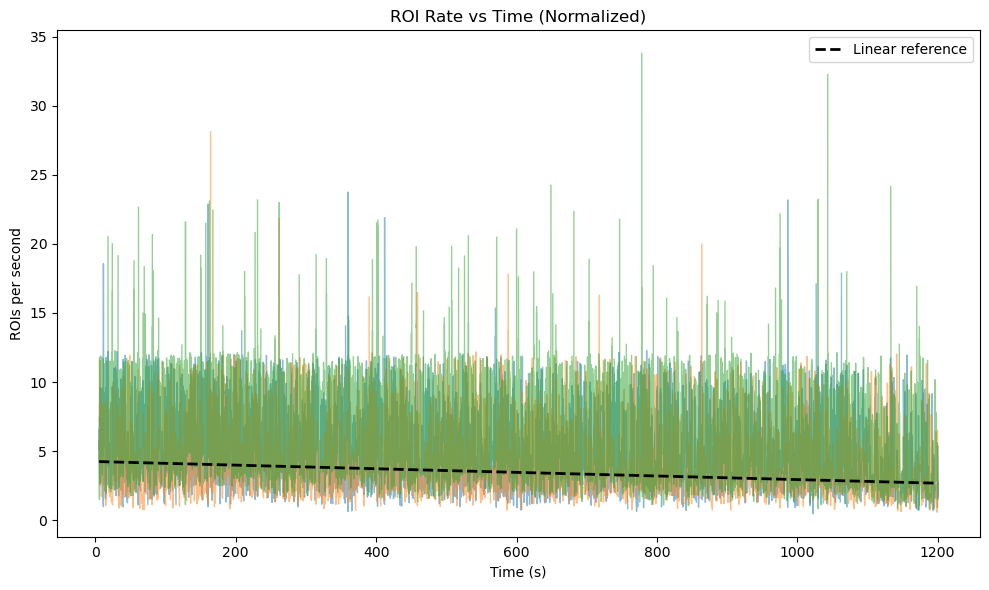

In [29]:

data_dir = data_dir

plt.figure(figsize=(10, 6))

first_x = first_y = None
last_x = last_y = None

for fname in sorted(os.listdir(data_dir)):
    if not fname.endswith(".csv"):
        continue

    df = pd.read_csv(os.path.join(data_dir, fname))

    # Ensure sorted by time
    df = df.sort_values("RunTime")

    # Compute differences
    dt = df["RunTime"].diff()
    droi = df["RoiNumber"].diff()

    # ROI rate (ROIs per second)
    roi_rate = droi / dt

    # Time associated with rate (midpoint)
    time_mid = df["RunTime"].iloc[1:].values

    # Drop first NaN
    roi_rate = roi_rate.iloc[1:]

    plt.plot(time_mid, roi_rate, alpha=0.5, linewidth=1)


    
    # Track global endpoints for reference line
    if first_x is None:
        first_x = time_mid[0]
        first_y = roi_rate.iloc[0]

    last_x = time_mid[-1]
    last_y = roi_rate.iloc[-1]

# Linear reference line across all data
plt.plot(
    [first_x, last_x],
    [first_y, last_y],
    linestyle="--",
    color="black",
    linewidth=2,
    label="Linear reference"
)

plt.xlabel("Time (s)")
plt.ylabel("ROIs per second")
plt.title("ROI Rate vs Time (Normalized)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
### somewhat intersting just tells you that average rois per second goes down over time from ~5 to 1

#### Kind of interesting this means this looks like the more rois you have the more off linear you are so there is a higher rate of rois being missed

## Look time exploration 

In [31]:
## from ExploringLookTimeandClass basic function for looping over data

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from pathlib import Path
# from typing import Optional

def _extract_adc_headers(hdr_path: Path):
    with open(hdr_path, 'r') as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                return [h.strip() for h in line.split(":", 1)[1].split(",")]
    raise ValueError(f"ADCFileFormat not found in header file: {hdr_path}")

def _load_adc_for_timeline(adc_path: Path, hdr_path: Path) -> pd.DataFrame:
    headers = _extract_adc_headers(hdr_path)
    df = pd.read_csv(adc_path, header=None)
    df.columns = headers[:df.shape[1]]
    # ensure numeric
    df['RunTime'] = pd.to_numeric(df['RunTime'], errors='coerce')
    df['InhibitTime'] = pd.to_numeric(df['InhibitTime'], errors='coerce')
    df = df.dropna(subset=['RunTime','InhibitTime']).sort_values('RunTime').reset_index(drop=True)
    return df

def plot_directory_timelines_time_inhibit_first(
    data_dir: str,
    abs_tol: float = 1e-6,
    save_path: Optional[str] = None,
    max_files: Optional[int] = None,
):
    """
    Scan a directory for *.hdr / *.adc pairs and plot a single figure with
    a horizontal 'state' strip per sample (red=inhibited first, blue=running).
    Returns a summary DataFrame with totals per sample.

    Parameters
    ----------
    data_dir : str
        Directory to scan recursively.
    abs_tol : float
        Small threshold to treat tiny ΔInhibit as zero (jitter).
    save_path : str or None
        If set, save the figure here (e.g., 'stacked_timelines.png').
    max_files : int or None
        Limit number of samples to plot (useful for quick previews).

    Returns
    -------
    summary_df : pd.DataFrame with columns:
        ['Sample', 'total_elapsed_s', 'total_running_s', 'total_inhibited_s',
         'final_runtime_s', 'final_inhibittime_s']
    """
    data_path = Path(data_dir)
    records = []  # (sample_name, df)

    # find hdr/adc pairs
    for hdr in sorted(data_path.rglob("*.hdr")):
        adc = hdr.with_suffix(".adc")
        if not adc.exists():
            continue
        try:
            df = _load_adc_for_timeline(adc, hdr)
            if len(df) >= 2:
                records.append((hdr.stem, df))
        except Exception as e:
            print(f"Skipping {hdr.stem}: {e}")

        if max_files and len(records) >= max_files:
            break

    if not records:
        print("No valid ADC/HDR pairs found.")
        return pd.DataFrame(columns=[
            'Sample','total_elapsed_s','total_running_s','total_inhibited_s',
            'final_runtime_s','final_inhibittime_s'
        ])

    # Determine global x-limit (max RunTime across samples)
    xmax = max(float(df['RunTime'].max()) for _, df in records)

    # One axes, stack rows by y offset (0..N-1)
    fig, ax = plt.subplots(figsize=(14, 1.1 * len(records) + 1))
    ytick_locs, ytick_labels = [], []

    summaries = []

    for row_idx, (name, df) in enumerate(records):
        line_spacing = 0.2  # smaller = closer lines, default was 1.0
        y0 = float(row_idx) * line_spacing

        # deltas
        dt = df['RunTime'].diff().to_numpy()
        dI = df['InhibitTime'].diff().to_numpy()

        # jitter & clamp
        dI = np.where(dI > abs_tol, dI, 0.0)
        dt = np.where(np.isfinite(dt), dt, 0.0)
        dI = np.where(np.isfinite(dI), dI, 0.0)
        dt = np.where(dt < 0, 0.0, dt)
        dI = np.clip(dI, 0.0, dt)

        x = df['RunTime'].to_numpy()
        total_inhib = 0.0
        total_run = 0.0

        # draw: inhibited (red) first, then running (blue)
        for i in range(1, len(df)):
            x0 = float(x[i-1]); x1 = float(x[i])
            if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
                continue
            di = float(dI[i])
            dr = float(dt[i] - di)

            cur = x0
            if di > 0:
                ax.plot([cur, cur+di], [y0, y0], color='red', linewidth=20, solid_capstyle='butt')
                cur += di
                total_inhib += di
            if dr > 0:
                ax.plot([cur, x1], [y0, y0], color='blue', linewidth=20, solid_capstyle='butt')
                total_run += dr

        ytick_locs.append(y0)
        ytick_labels.append(name)

        summaries.append({
            'Sample': name,
            'total_elapsed_s': total_run + total_inhib,
            'total_running_s': total_run,
            'total_inhibited_s': total_inhib,
            'final_runtime_s': float(df['RunTime'].iloc[-1]),
            'final_inhibittime_s': float(df['InhibitTime'].iloc[-1]),
        })

    # Style axes
    ax.set_xlim(0, xmax)
    ax.set_ylim(-line_spacing, len(records) * line_spacing)
    ax.set_yticks(ytick_locs)
    ax.set_yticklabels(ytick_labels, fontsize=9)
    ax.set_xlabel("Run Time (s)")
    ax.set_title("Instrument State Over Time (red = inhibited first, blue = running/waiting)")
    ax.grid(False)
    for sp in ['right','top']:
        ax.spines[sp].set_visible(False)

    # # Make a tiny legend line
    # leg_x0, leg_y = xmax * 0.02, len(records) - 0.8
    # ax.plot([leg_x0, leg_x0 + xmax*0.06], [leg_y, leg_y], color='red', linewidth=6)
    # ax.text(leg_x0 + xmax*0.07, leg_y, "Inhibited", va='center', fontsize=9)
    # leg_y2 = leg_y - 0.5
    # ax.plot([leg_x0, leg_x0 + xmax*0.06], [leg_y2, leg_y2], color='blue', linewidth=6)
    # ax.text(leg_x0 + xmax*0.07, leg_y2, "Running/Waiting", va='center', fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved stacked timeline to: {save_path}")
    plt.show()

    summary_df = pd.DataFrame(summaries).sort_values('Sample').reset_index(drop=True)
    return summary_df


Saved stacked timeline to: ../Figs/spawn/zygotes_looktime.png


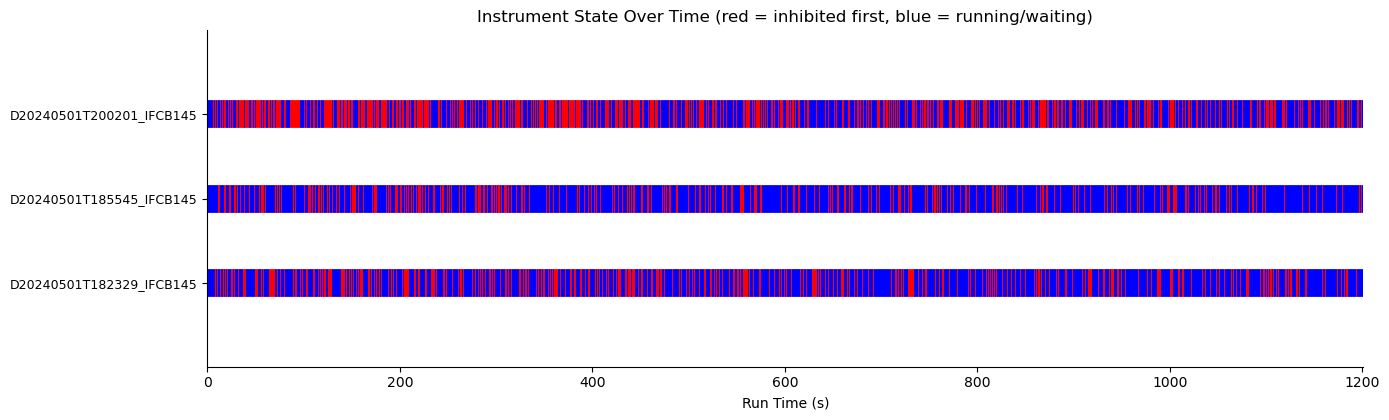

                     Sample  total_elapsed_s  total_running_s  \
0  D20240501T182329_IFCB145      1200.866747       821.690697   
1  D20240501T185545_IFCB145      1200.820054       876.066406   
2  D20240501T200201_IFCB145      1200.928255       682.816994   

   total_inhibited_s  final_runtime_s  final_inhibittime_s  
0         379.176050      1200.947639           379.187222  
1         324.753648      1200.894444           324.764375  
2         518.111261      1201.000556           518.121875  


In [32]:
summary_dir = plot_directory_timelines_time_inhibit_first(
    data_dir= "../IFCBData/spawn/zygotes/",
    save_path= "../Figs/spawn/zygotes_looktime.png"
)
print(summary_dir)

### Now lets see if we can do concentration estimates over time 
This is trickier because there are not any annotations on this data set but it is basically a monoculutre so i am just going to look at rois per volume over time

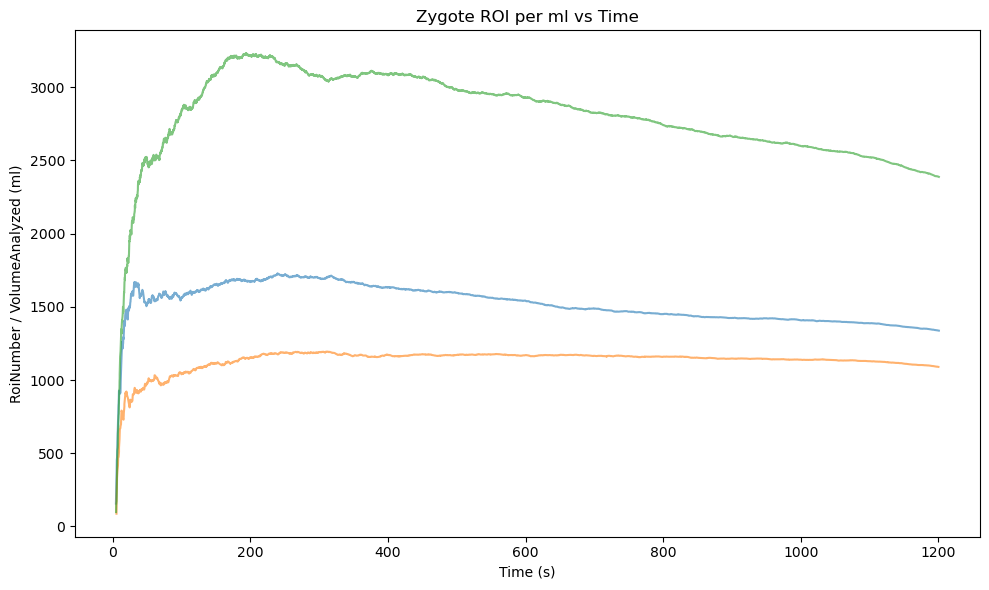

Saved: ../Figs/spawn/ZygoteROIpermlvsTime.png


In [36]:
# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# data_dir = "/path/to/your/merged_csv_directory"
# fig_dir  = "/path/to/your/figures"   # optional
# os.makedirs(fig_dir, exist_ok=True)  # optional

plt.figure(figsize=(10, 6))

for fname in sorted(os.listdir(data_dir)):
    if not fname.lower().endswith(".csv"):
        continue

    df = pd.read_csv(os.path.join(data_dir, fname))

    # Make sure required columns are numeric
    for col in ["RunTime", "RoiNumber", "VolumeAnalyzed"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Clean + sort
    df = df.dropna(subset=["RunTime", "RoiNumber", "VolumeAnalyzed"]).sort_values("RunTime")
    if len(df) < 2:
        continue

    # Avoid divide-by-zero
    df = df[df["VolumeAnalyzed"] > 0]
    if len(df) < 2:
        continue

    y = df["RoiNumber"] / df["VolumeAnalyzed"]

    plt.plot(df["RunTime"], y, linewidth=1.5, alpha=0.6)

plt.xlabel("Time (s)")
plt.ylabel("RoiNumber / VolumeAnalyzed (ml)")
plt.title("Zygote ROI per ml vs Time")
plt.tight_layout()

# Optional save
outpath = os.path.join(fig_dir, "ZygoteROIpermlvsTime.png")
plt.savefig(outpath, dpi=300, bbox_inches="tight")

plt.show()

print("Saved:", outpath)


#### I think this would be alot more powerful if annotated there is some detritus that hangs out not sure exactly what we are looking at here I could probably run model on this set and see what we get a fun side project for another day
